# Cortisol

Analysis of salivary cortisol samples thorughout Day 1 and Day 2. 

## Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import Formula

%run behav_starter.py

groups = ["Control", "Stress"]


Controls:  47
Stress:  49


## Helper Functions

In [2]:
def nan_cort_outlier(cort_df, out_sd = 4):
    # print out number of empty (nan) samples with insufficient cortisol
    print("Insufficient:", np.sum(pd.isna(cort_df['mean_cort'])))
    # print out insiffucient as percent of total collected samples
    print("Insufficient percent:", 100*np.sum(pd.isna(cort_df['mean_cort']))/len(cort_df))
    # print how many participants have at least 1 missing sample
    print("Participants missing samples:", len(np.unique(cort_df[pd.isna(cort_df["mean_cort"])]["subID"])))

    # nan out any outlier rows with z_cort > out_sd
    outlier_idx = cort_df[np.abs(cort_df["z_cort"]) > out_sd].index
    print("Outlier rows:")
    print(cort_df.iloc[outlier_idx])
    
    cort_df.loc[outlier_idx, "z_cort"] = np.nan
    cort_df.loc[outlier_idx, "mean_cort"] = np.nan

    return cort_df


def remove_partial_subs(df, sampstrs=None):
    if sampstrs is not None:
        use_df = df[np.isin(df["sample"], sampstrs)]
    else:
        use_df = df.copy()

    partsubs = np.unique(use_df[pd.isna(use_df["mean_cort"])]["subID"])
    print("Subjects excluded:", partsubs)
    print("Count:", len(partsubs))
    new_df = use_df[~np.isin(use_df["subID"], partsubs)]

    return new_df


## Day 1 Cortisol

In [3]:
cort_df = pd.read_csv(cortisol_data_file)[["Subject", "Label", "Time", "Cortisol (nmol/l) Mean"]]
cort_df = cort_df.rename(columns={"Cortisol (nmol/l) Mean": "mean_cort", "Subject": "subID", "Label": "label", "Time": "time"})
cort_df = cort_df[np.isin(cort_df["subID"], subIDs)]

sub2group = {}
for s in stress_subIDs:
    sub2group[s] = "Stress"
for s in ctrl_subIDs:
    sub2group[s] = "Control"

cort_df["day"] = cort_df["label"].apply(lambda s: s[0])
cort_df["sample"] = cort_df["label"].apply(lambda s: s[2])
cort_df["group"] = cort_df["subID"].apply(lambda s: sub2group[s])

# day 1 cortisol
cort_d1_df = cort_df[cort_df["day"] == '1'].reset_index(drop=True)
cort_d1_df["z_cort"] = scipy.stats.zscore(list(cort_d1_df["mean_cort"]), nan_policy='omit')

cort_d1_df_nooutlier = cort_d1_df[["subID", "group", "sample", "mean_cort", "z_cort"]].reset_index(drop=True)
cort_d1_df_nooutlier = nan_cort_outlier(cort_d1_df_nooutlier, out_sd=4)

cort_d1_df_clean = cort_d1_df_nooutlier[["subID", "group", "sample", "mean_cort"]]
cort_d1_df_clean["log_cort"] = np.log(cort_d1_df_clean["mean_cort"])



Insufficient: 23
Insufficient percent: 5.989583333333333
Participants missing samples: 15
Outlier rows:
     subID   group sample  mean_cort     z_cort
328     90  Stress      1     108.22   9.666025
329     90  Stress      2      98.65   8.759761
331     90  Stress      4     126.92  11.436885


In [4]:
# LME comparing cortisol trajectories between groups for Day 1
print("Day 1")
cort_d1_df_model = cort_d1_df_clean.copy().dropna()
cort_d1_df_model["sample"] = cort_d1_df_model["sample"].apply(lambda x: int(x))

nlme = importr('nlme')
base = importr('base')
rstats = importr('stats')

# convert data to R
with (ro.default_converter + pandas2ri.converter).context():
  r_data = ro.conversion.get_conversion().py2rpy(cort_d1_df_model)

formula_lme = Formula(f"log_cort ~ group * sample")
random_lme = Formula("~ 1 | subID")
model_lme = nlme.lme(fixed=formula_lme, random=random_lme, data=r_data)

with (ro.default_converter + pandas2ri.converter).context():
    anova_model = ro.conversion.get_conversion().rpy2py(rstats.anova(model_lme))

print(anova_model)


Day 1
              numDF  denDF     F-value       p-value
(Intercept)       1  260.0  680.807163  0.000000e+00
group             1   94.0    1.433162  2.342594e-01
sample            1  260.0   17.043318  4.925848e-05
group:sample      1  260.0   69.103419  5.329071e-15


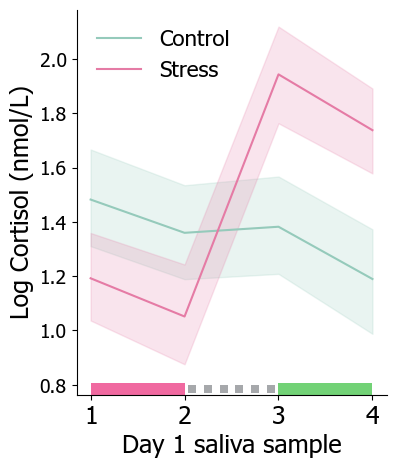

In [5]:
# visualize cortisol trajectories throughout Day 1
np.random.seed(0)

cort_d1_df_viz = cort_d1_df_clean.dropna()

figsize=(4, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

sns.lineplot(ax=ax, data=cort_d1_df_viz, x="sample", y="log_cort", hue="group", errorbar=('ci', 95), palette=group_colors, hue_order=groups)

ax.set_xlabel("Day 1 saliva sample", fontsize=18)
ax.set_ylabel("Log Cortisol (nmol/L)", fontsize=18)
ax.set_ylim(ax.get_ylim()[0]-0.05, ax.get_ylim()[1])# + text_yshift/2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=14)

ax.legend(frameon=False, fontsize=16)

rect_width = 1/np.diff(ax.get_xlim())[0]
rect_height = rect_width/10
dot_width = (2/3)*rect_height*figsize[1]/figsize[0]
dot_height = (2/3)*rect_height
for i, color in zip(np.arange(3), [secpt_color, rest_color, learn_color]):
    rect_position = (i-ax.get_xlim()[0])/np.diff(ax.get_xlim())[0]
    if i != 1:
        rect = mpl.patches.Rectangle((rect_position, 0), width=rect_width, height=rect_height, color=color, transform=ax.transAxes, clip_on=False, linewidth=0)
        ax.add_patch(rect)
    else:
        for j in range(6):
            dot_pos = rect_position + dot_width*j*2 + dot_width/2
            rect = mpl.patches.Rectangle((dot_pos, rect_height/6), width=dot_width, height=dot_height, color=color, transform=ax.transAxes, clip_on=False, linewidth=0)
            ax.add_patch(rect)

sns.despine()


Subjects excluded: [27 30 38 48 56 66 67 71 72 73 75 79 90 91 93]
Count: 15
Control: 95% CI [-0.39932281985467677, -0.09744774185220548], p = 0.0015200152001520015
Stress: 95% CI [0.4493224734586207, 0.8456436966930475], p = 0.0
Stress v Control: 95% CI [0.6469888551448791, 1.1445974958300653], p = 0.0


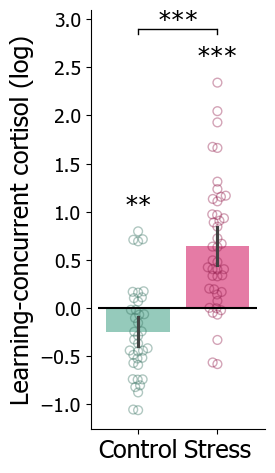

In [6]:
# visualize learning-concurrent cortisol from Day 1
cort_d1_df_react = remove_partial_subs(cort_d1_df_clean, sampstrs=['1', '3', '4']).pivot(index=["subID","group"], columns="sample", values="log_cort").reset_index()
cort_d1_df_react["cort_react"] = (cort_d1_df_react["4"] + cort_d1_df_react["3"])/2 - cort_d1_df_react["1"]

np.random.seed(0)

fig, ax = plt.subplots(1, 1, figsize=(3,5))
groups = ["Control", "Stress"]

sns.barplot(ax=ax, data=cort_d1_df_react, x="group", y="cort_react", hue="group", order=groups, hue_order=groups, palette=group_colors, saturation=1, n_boot=99999)
sns.swarmplot(ax=ax, data=cort_d1_df_react, x="group", y="cort_react", hue="group", order=groups, hue_order=groups, palette=dark_group_colors, dodge=False, alpha=0)

for groupi in range(len(groups)):
    x_data, y_data = ax.collections[groupi].get_offsets().T
    ax.scatter(x_data, y_data, color="None", s=40, alpha=0.4, edgecolor=dark_group_colors[groupi], linewidth=1)

ctrl_react = np.array(cort_d1_df_react[cort_d1_df_react["group"] == "Control"]["cort_react"])
ctrl_react = ctrl_react[~np.isnan(ctrl_react)]
stress_react = np.array(cort_d1_df_react[cort_d1_df_react["group"] == "Stress"]["cort_react"])
stress_react = stress_react[~np.isnan(stress_react)]

ctrl_CI, ctrl_p = simple_bootstrap(ctrl_react, null=0, iterations=99999)
stress_CI, stress_p = simple_bootstrap(stress_react, null=0, iterations=99999)
compare_CI, compare_p = simple_bootstrap_2group(stress_react, ctrl_react, null=0, iterations=99999)

ctrl_p = ctrl_p*2
stress_p = stress_p*2
compare_p = compare_p*2

print(f"Control: 95% CI {ctrl_CI}, p = {ctrl_p}")
print(f"Stress: 95% CI {stress_CI}, p = {stress_p}")
print(f"Stress v Control: 95% CI {compare_CI}, p = {compare_p}")

yshift = np.diff(ax.get_ylim())[0]*0.05
ax.text(0, np.max(ctrl_react)+yshift, pval2star(ctrl_p), horizontalalignment="center", fontsize=18)
ax.text(1, np.max(stress_react)+yshift, pval2star(stress_p), horizontalalignment="center", fontsize=18)
if compare_p != "":
    y = np.max([np.max(ctrl_react)+yshift, np.max(stress_react)+yshift])+2*yshift
    ax.text(0.5, y, pval2star(compare_p), horizontalalignment="center", fontsize=18)
    ax.hlines(y, 0, 1, color='k', linewidth=1)
    ax.vlines(0, y-yshift*0.3, y, color='k', linewidth=1, capstyle="projecting")
    ax.vlines(1, y-yshift*0.3, y, color='k', linewidth=1, capstyle="projecting")

plt.ylabel("Learning-concurrent cortisol (log)", fontsize=18)
plt.xlabel("")
plt.xticks(["Control", "Stress"], fontsize=18)
plt.yticks(fontsize=14)
plt.hlines(0, -0.5, 1.5, color='k')
sns.despine()
plt.tight_layout()


## Day 2 Cortisol

In [7]:
# day 2 cortisol
cort_d2_df = cort_df[cort_df["day"] == '2'].reset_index(drop=True)
cort_d2_df["z_cort"] = scipy.stats.zscore(list(cort_d2_df["mean_cort"]), nan_policy='omit')

cort_d2_df_nooutlier = cort_d2_df[["subID", "group", "sample", "mean_cort", "z_cort"]].reset_index(drop=True)
cort_d2_df_nooutlier = nan_cort_outlier(cort_d2_df_nooutlier, out_sd=4)

cort_d2_df_model = cort_d2_df_nooutlier[["subID", "group", "sample", "mean_cort"]]
cort_d2_df_model["log_cort"] = np.log(cort_d2_df_model["mean_cort"])
cort_d2_df_model = remove_partial_subs(cort_d2_df_model)
cort_d2_df_model["sample"] = cort_d2_df_model["sample"].apply(lambda x: int(x))


Insufficient: 10
Insufficient percent: 5.208333333333333
Participants missing samples: 9
Outlier rows:
     subID   group sample  mean_cort     z_cort
164     90  Stress      1      74.57   4.306405
165     90  Stress      2     199.50  12.269962
Subjects excluded: [23 25 43 50 56 66 71 83 90 93]
Count: 10


In [8]:
# LME comparing cortisol trajectories between groups for Day 2
print("Day 2")

nlme = importr('nlme')
base = importr('base')
rstats = importr('stats')

# convert data to R
with (ro.default_converter + pandas2ri.converter).context():
  r_data = ro.conversion.get_conversion().py2rpy(cort_d2_df_model)

formula_lme = Formula(f"log_cort ~ group * sample")
random_lme = Formula("~ 1 | subID")
model_lme = nlme.lme(fixed=formula_lme, random=random_lme, data=r_data)

with (ro.default_converter + pandas2ri.converter).context():
    anova_model = ro.conversion.get_conversion().rpy2py(rstats.anova(model_lme))

print(anova_model)


Day 2
              numDF  denDF     F-value   p-value
(Intercept)       1   84.0  691.086005  0.000000
group             1   84.0    0.247168  0.620375
sample            1   84.0    2.036111  0.157309
group:sample      1   84.0    1.141261  0.288447
